Logistic regression implementation for Spark. Based on https://github.com/apache/spark/blob/master/examples/src/main/python/logistic_regression.py

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
np.random.seed(0)

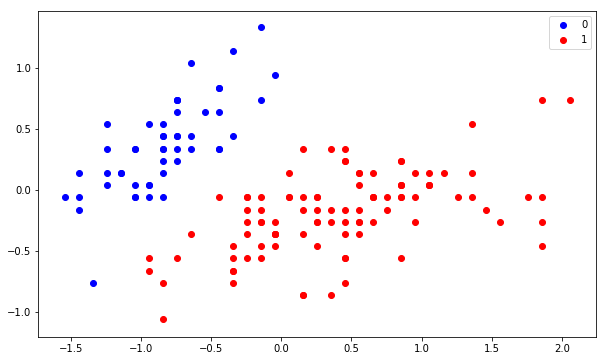

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]
X -= X.mean(axis=0)
y = (iris.target != 0) * 1
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()
data = np.concatenate([y.reshape((len(y), 1)),X], axis=1)
np.savetxt('/home/lsda/artificial.csv', data, delimiter=',')

N = X.shape[0]
D = X.shape[1]

In [3]:
def read_points_batch(points):

    points = list(points)
    
    # first entry is label, the other ones the data point
    arr = np.zeros((len(points), D + 1))
    
    # parse the strings to data points
    for i, s in enumerate(points):
        arr[i] = np.fromstring(s, dtype=np.float32, sep=',')
    
    return [arr]

points = sc.textFile("file:///home/lsda/artificial.csv")
points = points.mapPartitions(read_points_batch)
points.cache()

PythonRDD[2] at RDD at PythonRDD.scala:53

In [9]:
class LogisticRegressionSpark:
    
    def __init__(self, iter=100, lr=1.0, verbose=0):
        
        self.iter = iter
        self.lr = lr
        self.verbose = verbose
    
    def fit(self, points, n, d):
        """ Fits a logistic regression model
        on a large RDD 'points'
        """
        
        # random initialization of weights
        self._w = 2 * np.random.ranf(size=d) - 1
        
        # gradient descent
        for i in range(self.iter):
            
            if self.verbose > 0:
                print("Iteration %i" % (i + 1))
            
            # update weights via distributed gradient computation
            grad = points.map(lambda m: self._gradient(m, self._w))
            grad = grad.reduce(self._add)
            
            # do one update step
            self._w -= self.lr * (1.0 / n) * grad
            
        if self.verbose > 0:
            print("Final weights: {}".format(str(self._w)))
    
    def predict_proba(self, Xsmall):
        """ Outputs the class probabilties
        """
        
        s = np.dot(Xsmall, self._w)
        return 1.0 / (1.0 + np.exp(-s))
    
    def _gradient(self, matrix, weights):
        """ Computes the gradient.
        """
        
        y = matrix[:, 0]
        X = matrix[:, 1:]  

        yXT = y * X.T
        s = np.exp(y * X.dot(weights))
        
        grad = - (1.0 / (1.0 + s)) * yXT
        grad = grad.sum(1)

        return grad

    def _add(self, x, y):

        return x + y

In [10]:
model = LogisticRegressionSpark(iter=100, lr=1.0, verbose=0)
model.fit(points, N, D)

NameError: name 'm' is not defined

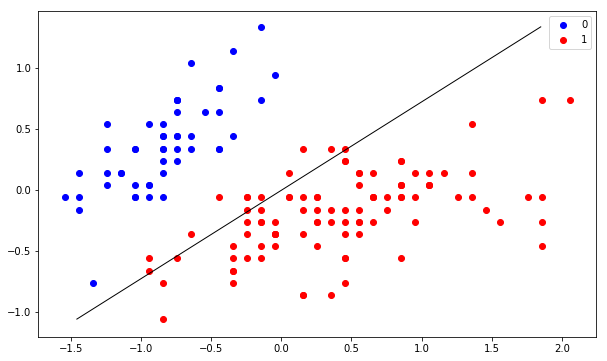

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_proba(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');